In [12]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd

# Rasterstats contains the zonalstatistics function 
# that you will use to extract raster values
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es

# Set consistent plotting style
sns.set_style("white")
sns.set(font_scale=1.5)

In [3]:
######### USER #########
#select domain
domain = 'WY'

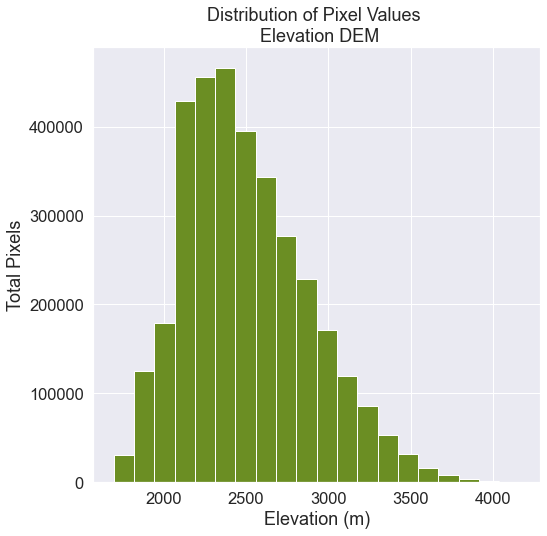

In [37]:
# raster path
raster_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/DEM_'+domain+'.tif'

#fig paths 
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/'+domain+'/'

#station path 
station_path = '/nfs/attic/dfh/Aragon2/CSOdata/'+domain+'/CSO_SNOTEL_sites.geojson'
#Aragon2/CSOdata/
#Aragon2/CSOdmn/
#Aragon2/CSOfigs/

#https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/extract-data-from-raster/
#raster_path = '/nfs/attic/dfh/Aragon2/DEM_WY_new.tif'
#raster_path = '/nfs/attic/dfh/Aragon2/Notebooks/DEM_WY_res100_WGS84.tif'
raster_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/DEM_WY.tif'

with rio.open(raster_path) as sjer_lidar_chm_src:
    # Masked = True sets no data values to np.nan if they are in the metadata
    SJER_chm_data = sjer_lidar_chm_src.read(1, masked=True)
    sjer_chm_meta = sjer_lidar_chm_src.profile

# Explore the data by plotting a histogram with earthpy
ax=ep.hist(SJER_chm_data,
        figsize=(8,8),
        colors="olivedrab",
        xlabel="Elevation (m)",
        ylabel="Total Pixels",
        title="Distribution of Pixel Values \n Elevation DEM")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                     style='plain')

In [5]:
raster = rio.open(raster_path)
raster.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 1382,
 'height': 2476,
 'count': 1,
 'crs': CRS.from_epsg(32612),
 'transform': Affine(100.0, 0.0, 487200.0,
        0.0, -100.0, 4937700.0)}

In [7]:
import xarray as xr
from affine import Affine
dem = xr.open_rasterio(raster_path)
transform = Affine.from_gdal(*dem.attrs['transform'])
nx, ny = dem.sizes['x'], dem.sizes['y']
x, y = np.meshgrid(np.arange(nx)+0.5, np.arange(ny)+0.5) * transform
dem

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  


<xarray.DataArray (band: 1, y: 2476, x: 1382)>
[3421832 values with dtype=int16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.938e+06 4.938e+06 4.937e+06 ... 4.69e+06 4.69e+06
  * x        (x) float64 4.872e+05 4.874e+05 4.874e+05 ... 6.252e+05 6.254e+05
Attributes:
    transform:      (100.0, 0.0, 487200.0, 0.0, -100.0, 4937700.0)
    crs:            +init=epsg:32612
    res:            (100.0, 100.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('elevation',)
    AREA_OR_POINT:  Area

# GET pixel location

In [9]:
stn = gpd.read_file(station_path)
new=stn.to_crs('epsg:32612')
new.head()

,code,longitude,latitude,name,elevation_m,easting,northing,geometry
0,314_WY_SNTL,-110.445442,43.940189,Base Camp,2151.887939453125,544505.845453,4.865379e+06,POINT (544505.845 4865379.298)
1,347_MT_SNTL,-111.128029,44.508320,Black Bear,2490.216064453125,489823.440274,4.928341e+06,POINT (489823.440 4928341.300)
2,350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,596129.923439,4.914418e+06,POINT (596129.923 4914418.231)
3,353_WY_SNTL,-110.609734,42.964001,Blind Bull Sum,2636.52001953125,531828.554679,4.756891e+06,POINT (531828.555 4756891.027)
4,379_WY_SNTL,-109.670212,43.697330,Burroughs Creek,2667,607155.527746,4.839116e+06,POINT (607155.528 4839116.044)


In [10]:
#get indicies (since python - indexing starts at 0, but fortran starts at 1)

with rio.open(raster_path) as src:
    rows, cols = rio.transform.rowcol(src.transform, new.geometry.centroid.x, new.geometry.centroid.y)
print(rows)
print(cols)

[723, 93, 232, 1808, 985, 2161, 1620, 1754, 903, 1386, 518, 1332, 1337, 1487, 426, 1202, 1572, 1638, 1194, 2315, 509, 2328, 2295, 124, 122, 247, 932, 2030, 486, 1974]
[573, 26, 1089, 446, 1199, 279, 776, 1139, 186, 585, 260, 833, 1036, 926, 394, 1136, 826, 982, 198, 202, 392, 512, 406, 798, 892, 464, 886, 462, 750, 262]


In [27]:
#northing/easting of each station
xval = []
yval = []
for i in range(len(rows)):
    print(dem['x'][cols[i]].values,dem['y'][rows[i]].values)
    xval.append(int(dem['x'][cols[i]].values))
    yval.append(int(dem['y'][rows[i]].values))
    
d = {'x': xval, 'y': yval}
df = pd.DataFrame(data=d)

544550.0 4865350.0
489850.0 4928350.0
596150.0 4914450.0
531850.0 4756850.0
607150.0 4839150.0
515150.0 4721550.0
564850.0 4775650.0
601150.0 4762250.0
505850.0 4847350.0
545750.0 4799050.0
513250.0 4885850.0
570550.0 4804450.0
590850.0 4803950.0
579850.0 4788950.0
526650.0 4895050.0
600850.0 4817450.0
569850.0 4780450.0
585450.0 4773850.0
507050.0 4818250.0
507450.0 4706150.0
526450.0 4886750.0
538450.0 4704850.0
527850.0 4708150.0
567050.0 4925250.0
576450.0 4925450.0
533650.0 4912950.0
575850.0 4844450.0
533450.0 4734650.0
562250.0 4889050.0
513450.0 4740250.0


In [29]:
from shapely.geometry import Point
# creating a geometry column 
geometry = [Point(xy) for xy in zip(xval, yval)]
# Coordinate reference system : WGS84
crs = raster.crs
# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [30]:
gdf

,x,y,geometry
0,544550,4865350,POINT (544550.000 4865350.000)
1,489850,4928350,POINT (489850.000 4928350.000)
2,596150,4914450,POINT (596150.000 4914450.000)
3,531850,4756850,POINT (531850.000 4756850.000)
4,607150,4839150,POINT (607150.000 4839150.000)
5,515150,4721550,POINT (515150.000 4721550.000)
6,564850,4775650,POINT (564850.000 4775650.000)
7,601150,4762250,POINT (601150.000 4762250.000)
8,505850,4847350,POINT (505850.000 4847350.000)
9,545750,4799050,POINT (545750.000 4799050.000)


In [42]:
topo = raster.read(1)
# CLEANUP: Set CHM values of 0 to NAN (no data or not a number)
#topo[topo == 0] = np.nan

# View summary statistics of canopy height model after cleaning up the data
print('Mean:', np.nanmean(topo))
print('Max:', np.nanmax(topo))
print('Min:', np.nanmin(topo))

Mean: 2500.943688936219
Max: 4160
Min: 1697


In [6]:
stn

type(SJER_plots_points)

SJER_plots_points.head()

,code,longitude,latitude,name,elevation_m,easting,northing,geometry
0,314_WY_SNTL,-110.445442,43.940189,Base Camp,2151.887939453125,544505.845453,4.865379e+06,POINT (-110.44544 43.94019)
1,347_MT_SNTL,-111.128029,44.508320,Black Bear,2490.216064453125,489823.440274,4.928341e+06,POINT (-111.12803 44.50832)
2,350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,596129.923439,4.914418e+06,POINT (-109.79333 44.37667)
3,353_WY_SNTL,-110.609734,42.964001,Blind Bull Sum,2636.52001953125,531828.554679,4.756891e+06,POINT (-110.60973 42.96400)
4,379_WY_SNTL,-109.670212,43.697330,Burroughs Creek,2667,607155.527746,4.839116e+06,POINT (-109.67021 43.69733)


# Plot 

In [32]:
# Open data in read ('r') mode
with rio.open(raster_path) as src:

    # Project stn data to match data
    WGS84 = stn.to_crs(src.crs)

    # Crop raster data to stn boundary
    data_crop, meta_crop = es.crop_image(
        src, WGS84)

# Define plotting extent using cropped array and transform from metadata
crop_plot_extent = plotting_extent(
    data_crop[0], meta_crop["transform"])

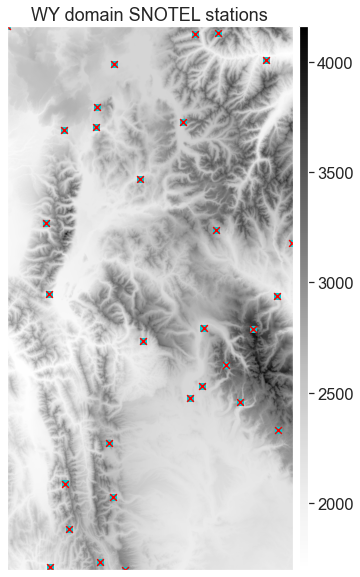

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))

ep.plot_bands(dem,
              extent=crop_plot_extent, # Set spatial extent 
              cmap='Greys',
              title="WY domain SNOTEL stations",
              scale=False,
              ax=ax)

new.plot(ax=ax, marker='s', markersize=45, color='darkturquoise')
#new.plot(ax=ax, marker='x', markersize=45, color='blue')
gdf.plot(ax=ax, marker='x', markersize=45, color='red')

#ax.set_axis_off()
plt.show()

In [43]:
# Extract zonal stats
sjer_tree_heights = rs.zonal_stats(station_path,
                                   SJER_chm_data,
                                   nodata=-999,
                                   affine=sjer_chm_meta['transform'],
                                   geojson_out=True,
                                   copy_properties=True,
                                   stats="count min mean max median")

# Turn extracted data into a pandas geodataframe
SJER_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)
SJER_lidar_height_df.head()

,geometry,code,longitude,latitude,name,elevation_m,easting,northing,count,min,mean,max,median
0,POINT (-110.44544 43.94019),314_WY_SNTL,-110.445442,43.940189,Base Camp,2151.887939453125,544505.845453,4.865379e+06,0,None,None,None,None
1,POINT (-111.12803 44.50832),347_MT_SNTL,-111.128029,44.508320,Black Bear,2490.216064453125,489823.440274,4.928341e+06,0,None,None,None,None
2,POINT (-109.79333 44.37667),350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,596129.923439,4.914418e+06,0,None,None,None,None
3,POINT (-110.60973 42.96400),353_WY_SNTL,-110.609734,42.964001,Blind Bull Sum,2636.52001953125,531828.554679,4.756891e+06,0,None,None,None,None
4,POINT (-109.67021 43.69733),379_WY_SNTL,-109.670212,43.697330,Burroughs Creek,2667,607155.527746,4.839116e+06,0,None,None,None,None


NameError: name 'SJER_lidar_height_df' is not defined

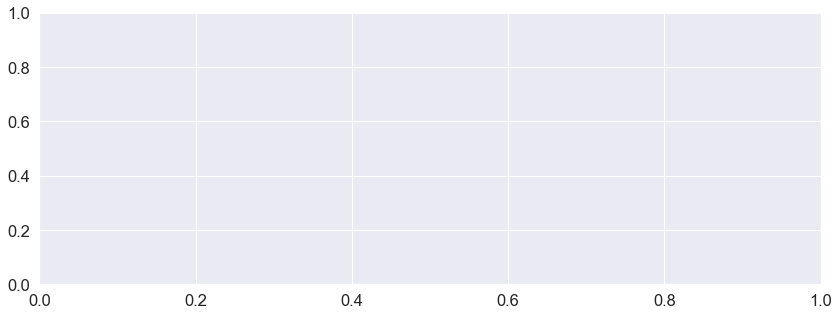

In [36]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.bar(SJER_lidar_height_df['code'],
       SJER_lidar_height_df['max'],
       color="blue")

ax.set(xlabel='Plot ID', ylabel='Elevation',
       title='Station Elevation')

plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

### Extract pixel location

In [77]:
from __future__ import division
#from geopy.geocoders import Nominatim
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np

In [80]:
filename = raster_path
gdal_data = gdal.Open(filename)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()
data_array = gdal_data.ReadAsArray().astype(np.float)

row =[]
col =[]

gdata = gdal.Open(raster_path)
gt = gdata.GetGeoTransform()
data = gdata.ReadAsArray().astype(np.float)
for i in range(len(new.geometry.centroid.x.values)):
    row.append(int((new.geometry.centroid.x.values[i] - gt[0])/gt[1]))
    col.append(int((new.geometry.centroid.y.values[i] - gt[3])/gt[5]))


print(row)
print(col)

[573, 26, 1089, 446, 1199, 279, 776, 1139, 186, 585, 260, 833, 1036, 926, 394, 1136, 826, 982, 198, 202, 392, 512, 406, 798, 892, 464, 886, 462, 750, 262]
[723, 93, 232, 1808, 985, 2161, 1620, 1754, 903, 1386, 518, 1332, 1337, 1487, 426, 1202, 1572, 1638, 1194, 2315, 509, 2328, 2295, 124, 122, 247, 932, 2030, 486, 1974]


In [112]:
from osgeo import ogr, osr, gdal

def extract_point_from_raster(point, data_source, band_number=1):
    """Return floating-point value that corresponds to given point."""

    # Convert point co-ordinates so that they are in same projection as raster
    point_sr = point.GetSpatialReference()
    raster_sr = osr.SpatialReference()
    raster_sr.ImportFromWkt(data_source.GetProjection())
    transform = osr.CoordinateTransformation(point_sr, raster_sr)
    point.Transform(transform)

    # Convert geographic co-ordinates to pixel co-ordinates
    x, y = point.GetX(), point.GetY()
    forward_transform = Affine.from_gdal(*data_source.GetGeoTransform())
    reverse_transform = ~forward_transform
    px, py = reverse_transform * (x, y)
    px, py = int(px + 0.5), int(py + 0.5)

    # Extract pixel value
    band = data_source.GetRasterBand(band_number)
    structval = band.ReadRaster(px, py, 1, 1, buf_type=gdal.GDT_Float32)
    result = struct.unpack('f', structval)[0]
    if result == band.GetNoDataValue():
        result = float('nan')
    return px, py, result

px,py,result = extract_point_from_raster(layer, raster_path, band_number=1)

AttributeError: type object 'object' has no attribute '__getattr__'

In [119]:
import affine
ds = gdal.Open(raster_path)

def retrieve_pixel_value(geo_coord, data_source):
    """Return floating-point value that corresponds to given point."""
    x, y = geo_coord[0], geo_coord[1]
    forward_transform =  \
        affine.Affine.from_gdal(*data_source.GetGeoTransform())
    reverse_transform = ~forward_transform
    px, py = reverse_transform * (x, y)
    px, py = int(px + 0.5), int(py + 0.5)
    pixel_coord = px, py

    data_array = np.array(data_source.GetRasterBand(1).ReadAsArray())
    return px, py, data_array[pixel_coord[0]][pixel_coord[1]]

px, py, value = retrieve_pixel_value((-110.44544219970703, 43.940189361572266), ds)
print(px,py,value)

2415 2201 2114


In [84]:
from osgeo import ogr, osr, gdal

driver = gdal.GetDriverByName('GTiff')
filename = raster_path #path to raster
dataset = gdal.Open(filename)
band = dataset.GetRasterBand(1)

cols = dataset.RasterXSize
rows = dataset.RasterYSize

transform = dataset.GetGeoTransform()

xOrigin = transform[0]
yOrigin = transform[3]
pixelWidth = transform[1]
pixelHeight = -transform[5]

data = band.ReadAsArray(0, 0, cols, rows)

x = new.geometry.centroid.x.values.tolist()
y = new.geometry.centroid.y.values.tolist()
points_list=list(zip(x, y))

for point in points_list:
    col = int((point[0] - xOrigin) / pixelWidth)
    row = int((yOrigin - point[1] ) / pixelHeight)

    print (col,row, data[row][col])

573 723 2145
26 93 2493
1089 232 3006
446 1808 2716
1199 985 2680
279 2161 2351
776 1620 2457
1139 1754 2871
186 903 2831
585 1386 2069
260 518 2233
833 1332 2680
1036 1337 2988
926 1487 2382
394 426 2403
1136 1202 2863
826 1572 2519
982 1638 2565
198 1194 2506
202 2315 2334
392 509 2115
512 2328 2470
406 2295 2757
798 124 2575
892 122 2186
464 247 2440
886 932 2934
462 2030 2639
750 486 2827
262 1974 2487


In [114]:
a = stn.geometry.centroid.x.values.tolist()
b = stn.geometry.centroid.y.values.tolist()
x=list(zip(a, b))
x

[(-110.44544219970703, 43.940189361572266),
 (-111.1280288696289, 44.50831985473633),
 (-109.79332733154297, 44.376670837402344),
 (-110.60973358154297, 42.9640007019043),
 (-109.67021179199219, 43.697330474853516),
 (-110.8148193359375, 42.64590072631836),
 (-110.20230102539062, 43.1309700012207),
 (-109.75892639160156, 43.006568908691406),
 (-110.9278335571289, 43.77933120727539),
 (-110.43495178222656, 43.342979431152344),
 (-110.8343505859375, 44.126121520996094),
 (-110.12943267822266, 43.38938903808594),
 (-109.8781509399414, 43.38331985473633),
 (-110.01661682128906, 43.249298095703125),
 (-110.6662826538086, 44.2086181640625),
 (-109.75199890136719, 43.50278091430664),
 (-110.14006805419922, 43.17387008666992),
 (-109.94947052001953, 43.11265182495117),
 (-110.91258239746094, 43.516868591308594),
 (-110.90989685058594, 42.50749969482422),
 (-110.6691665649414, 44.133609771728516),
 (-110.53202819824219, 42.49489974975586),
 (-110.66148376464844, 42.52516174316406),
 (-110.15650

In [100]:
geom = ogr.Open(station_path)

In [108]:
layer=geom.GetLayer(0)

In [110]:
n_feat = 0
for feat in layer:

    print (feat.GetField('NAME'))

    n_feat += 1


Base Camp
Black Bear
Blackwater
Blind Bull Sum
Burroughs Creek
Cottonwood Creek
East Rim Divide
Elkhart Park G.S.
Grand Targhee
Granite Creek
Grassy Lake
Gros Ventre Summit
Gunsight Pass
Kendall R.S.
Lewis Lake Divide
Little Warm
Loomis Park
New Fork Lake
Phillips Bench
Salt River Summit
Snake River Station
Snider Basin
Spring Creek Divide
Sylvan Lake
Sylvan Road
Thumb Divide
Togwotee Pass
Triple Peak
Two Ocean Plateau
Willow Creek


In [60]:
import rioxarray
import rasterio as rio
stn = gpd.read_file(station_path)
dem = rioxarray.open_rasterio(raster_path)

print(dem.rio.crs)
dem4326 = dem.rio.reproject("epsg:4326")
dem4326.rio.crs

EPSG:32612


CRS.from_epsg(4326)